In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.gridspec as gridspec

# Set random seed for reproducibility
np.random.seed(42)

# Set the style for our plots
sns.set_palette("viridis")

# Load and Explore the Data

In [ ]:
# Fetch the California housing dataset
housing = fetch_california_housing()

# Create a DataFrame for easier handling
housing_df = pd.DataFrame(housing.data,columns=housing.feature_names)
housing_df['MedHouseVal'] = housing.target

# Print basic information about the dataset
print("Dataset shape:", housing_df.shape)
print("\nFeature names:", housing.feature_names)
print("\nTarget name:", housing.target_names)
print("\nDataset overview:")
housing_df.head()


In [ ]:
# Generate summary statistics for all variables
print("\nSummary statistics:")
summary_stats = housing_df.describe()
summary_stats

In [ ]:
# Create a correlation heatmap to understand relationships between variables
plt.figure(figsize=(12, 8))
correlation_matrix = housing_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of California Housing Data', fontsize=16)
plt.show()

# Data Exploration

In [ ]:
# Create a function for saving figures
def save_fig(fig, filename, dpi=300):
    fig.savefig(filename, dpi=dpi, bbox_inches='tight')
    
# 2.1 Create a scatter plot of MedInc vs. MedHouseVal
plt.figure(figsize=(10, 6))
plt.scatter(housing_df['MedInc'], housing_df['MedHouseVal'], alpha=0.5, color='blue')
plt.title('Median Income vs. Median House Value', fontsize=16)
plt.xlabel('Median Income (scaled to $10,000s)', fontsize=14)
plt.ylabel('Median House Value (scaled to $100,000s)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Create histogram distribution for MedInc and MedHouseVal
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Median Income distribution
sns.histplot(housing_df['MedInc'], kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribution of Median Income', fontsize=14)
axes[0].set_xlabel('Median Income (scaled to $10,000s)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].axvline(housing_df['MedInc'].mean(), color='red', linestyle='--', label=f'Mean: {housing_df["MedInc"].mean():.2f}')
axes[0].axvline(housing_df['MedInc'].median(), color='green', linestyle='--', label=f'Median: {housing_df["MedInc"].median():.2f}')
axes[0].legend()

# Median House Value distribution
sns.histplot(housing_df['MedHouseVal'], kde=True, ax=axes[1], color='green')
axes[1].set_title('Distribution of Median House Value', fontsize=14)
axes[1].set_xlabel('Median House Value (scaled to $100,000s)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].axvline(housing_df['MedHouseVal'].mean(), color='red', linestyle='--', label=f'Mean: {housing_df["MedHouseVal"].mean():.2f}')
axes[1].axvline(housing_df['MedHouseVal'].median(), color='blue', linestyle='--', label=f'Median: {housing_df["MedHouseVal"].median():.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()


# PreProcess the Data

In [ ]:
# Focus only on MedInc 
X = housing_df[['MedInc']].values
y = housing_df['MedHouseVal'].values

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

In [ ]:
# Standardization
# Helps with optimization stability
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Store original unscaled data for visualization
X_train_orig = X_train.copy()
X_test_orig = X_test.copy()

# Build a Linear Regression Model

In [ ]:
def batch_gradient_descent(X, y, learning_rate=0.01, iterations=1000, tolerance=1e-5):
# Get number of samples and features
    n_samples, n_features = X.shape
    
    # Initialize weights and bias
    weights = np.zeros(n_features)
    bias = 0
    
    # Initialize cost history to track convergence
    cost_history = []
    
    # Main gradient descent loop
    for i in range(iterations):
        # Calculate predictions
        y_pred = np.dot(X, weights) + bias
        
        # Calculate gradients
        dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
        db = (1/n_samples) * np.sum(y_pred - y)
        
        # Update parameters
        weights -= learning_rate * dw
        bias -= learning_rate * db
        
        # Calculate cost
        cost = (1/(2*n_samples)) * np.sum((y_pred - y)**2)
        cost_history.append(cost)
        
        # Check for convergence
        if i > 0 and abs(cost_history[i] - cost_history[i-1]) < tolerance:
            print(f"Converged after {i} iterations")
            break
    
    return weights, bias, cost_history

In [ ]:
def stochastic_gradient_descent(X, y, learning_rate=0.01, iterations=1000, tolerance=1e-5):
     # Get number of samples and features
    n_samples, n_features = X.shape
    
    # Initialize weights and bias
    weights = np.zeros(n_features)
    bias = 0
    
    # Initialize cost history to track convergence
    cost_history = []
    
    # Main gradient descent loop (epochs)
    for epoch in range(iterations):
        # Shuffle the data at the beginning of each epoch
        indices = np.random.permutation(n_samples)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        # Initialize epoch loss
        epoch_cost = 0
        
        # Process each sample
        for i in range(n_samples):
            # Get a single sample
            xi = X_shuffled[i:i+1]
            yi = y_shuffled[i:i+1]
            
            # Calculate prediction for this sample
            y_pred = np.dot(xi, weights) + bias
            
            # Calculate gradients based on this single sample
            dw = np.dot(xi.T, (y_pred - yi))
            db = np.sum(y_pred - yi)
            
            # Update parameters
            weights -= learning_rate * dw
            bias -= learning_rate * db
            
            # Accumulate sample loss
            epoch_cost += (1/2) * ((y_pred - yi)**2)
        
        # Calculate average cost for this epoch
        avg_epoch_cost = epoch_cost / n_samples
        cost_history.append(avg_epoch_cost[0])
        
        # Check for convergence
        if epoch > 0 and abs(cost_history[epoch] - cost_history[epoch-1]) < tolerance:
            print(f"Converged after {epoch} epochs")
            break
    
    return weights, bias, cost_history

In [ ]:
# TRAIN THE MODELS

print("\nTraining Batch Gradient Descent model...")

bgd_weights, bgd_bias, bgd_cost_history = batch_gradient_descent(
    X_train_scaled, y_train, learning_rate=0.1, iterations=1500, tolerance=1e-6
)

print("\nTraining Stochastic Gradient Descent model...")
sgd_weights, sgd_bias, sgd_cost_history = stochastic_gradient_descent(
    X_train_scaled, y_train, learning_rate=0.01, iterations=100, tolerance=1e-6
)


# Make Predictions

In [ ]:
# Make predictions with our custom implementations
# Need to transform back from scaled to original for visualization
y_pred_bgd = scaler_X.transform(X_test) * bgd_weights + bgd_bias
y_pred_sgd = scaler_X.transform(X_test) * sgd_weights + sgd_bias


In [ ]:
# EVALUATE MODEL PERFORMANCE

# Calculate metrics for custom implementations
bgd_mse = mean_squared_error(y_test, y_pred_bgd)
bgd_r2 = r2_score(y_test, y_pred_bgd)

sgd_mse = mean_squared_error(y_test, y_pred_sgd)
sgd_r2 = r2_score(y_test, y_pred_sgd)


# Print evaluation metrics
print("\nModel Evaluation:")
print(f"Custom Batch Gradient Descent: MSE = {bgd_mse:.4f}, R² = {bgd_r2:.4f}")
print(f"Custom Stochastic Gradient Descent: MSE = {sgd_mse:.4f}, R² = {sgd_r2:.4f}")


In [ ]:
#PREDICT HOUSE VALUE FOR SPECIFIC INCOME

#district with median income of $80,000 (MedInc = 8.0)
new_income = np.array([[8.0]])
new_income_scaled = scaler_X.transform(new_income)

# Make predictions
pred_bgd = new_income_scaled * bgd_weights + bgd_bias
pred_sgd = new_income_scaled * sgd_weights + sgd_bias


print("\nPredictions for a district with median income of $80,000:")
print(f"Custom Batch Gradient Descent: ${pred_bgd[0][0] * 100000:.2f}")
print(f"Custom Stochastic Gradient Descent: ${pred_sgd[0][0] * 100000:.2f}")


# Visualize the Results

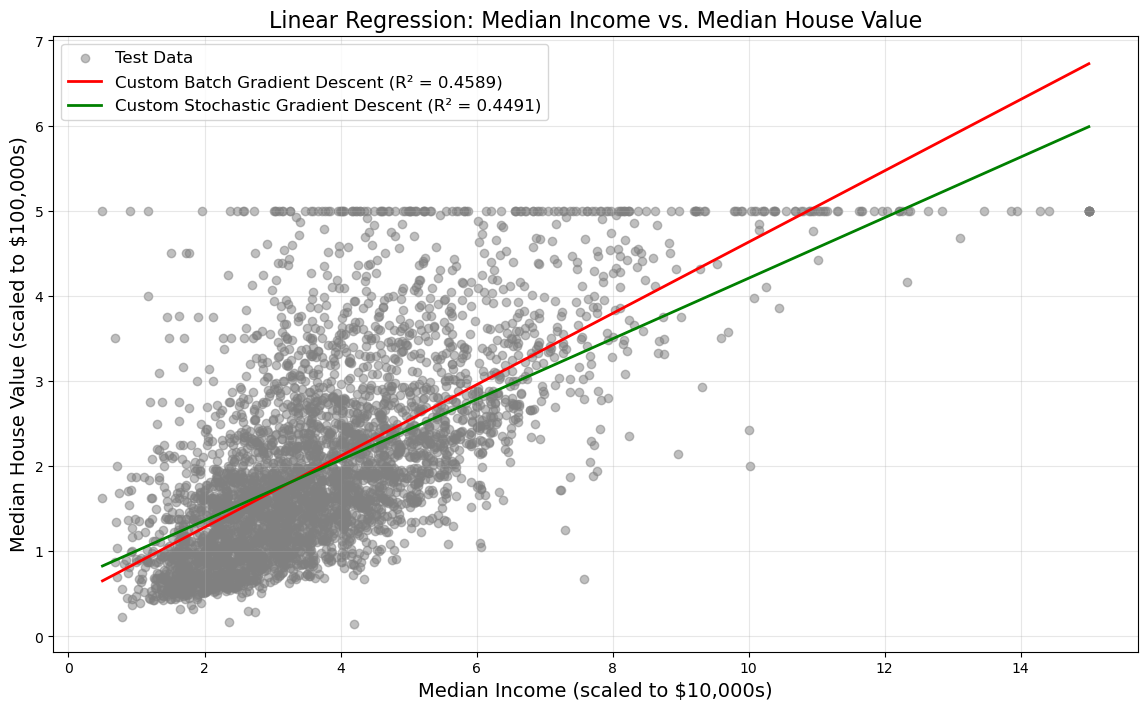

In [31]:
# Plot regression lines on test data
# Create a new figure with all models for comparison
plt.figure(figsize=(14, 8))

# Scatter test data points
plt.scatter(X_test, y_test, alpha=0.5, label='Test Data', color='gray')

# Sort X_test for smooth line plotting
sorted_indices = np.argsort(X_test.flatten())
X_test_sorted = X_test[sorted_indices]
y_pred_bgd_sorted = y_pred_bgd[sorted_indices]
y_pred_sgd_sorted = y_pred_sgd[sorted_indices]

plt.plot(X_test_sorted, y_pred_bgd_sorted, color='red', linewidth=2, 
         label=f'Custom Batch Gradient Descent (R² = {bgd_r2:.4f})')
plt.plot(X_test_sorted, y_pred_sgd_sorted, color='green', linewidth=2, 
         label=f'Custom Stochastic Gradient Descent (R² = {sgd_r2:.4f})')



plt.title('Linear Regression: Median Income vs. Median House Value', fontsize=16)
plt.xlabel('Median Income (scaled to $10,000s)', fontsize=14)
plt.ylabel('Median House Value (scaled to $100,000s)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.show()

# Train a Model Using Multiple Features

Converged after 307 iterations


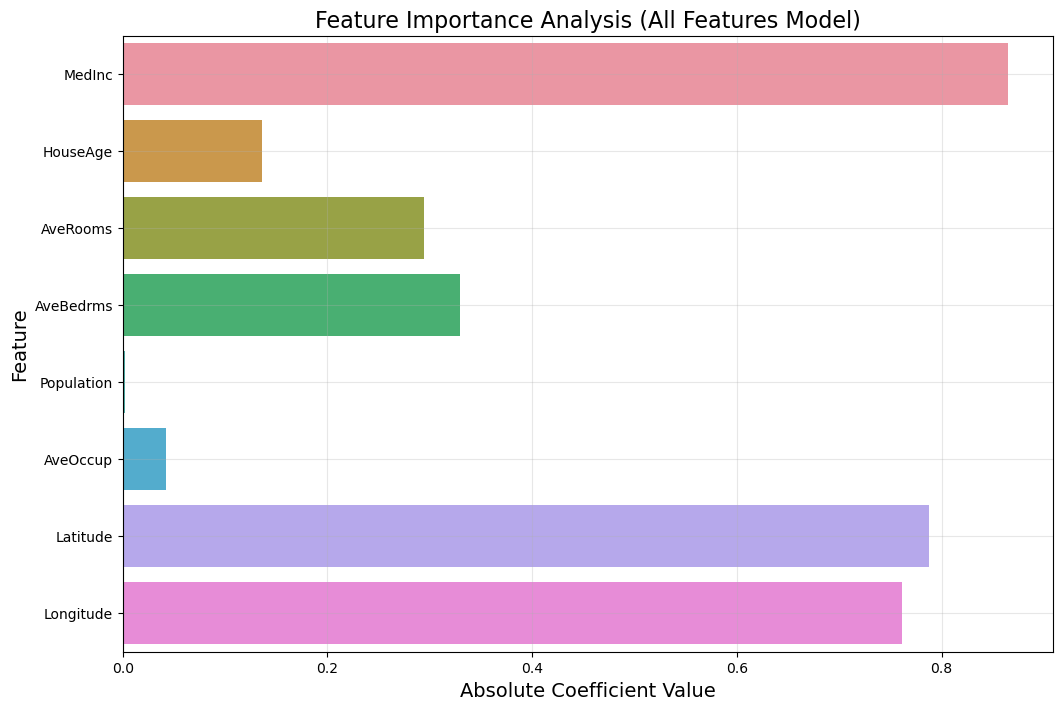

In [26]:
def train_evaluate_with_weights(features):
    X = housing_df[features].values
    y = housing_df.MedHouseVal.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    
    # Train BGD model
    bgd_w, bgd_b, _ = batch_gradient_descent(X_train_scaled, y_train, 0.1, 1500)
    
    return bgd_w  # Return weights for feature importance

# Get feature importance from all features model
all_features = housing.feature_names
bgd_weights_all = train_evaluate_with_weights(all_features)

# Create feature importance plot
plt.figure(figsize=(12, 8))
sns.barplot(x=np.abs(bgd_weights_all), y=all_features)
plt.title('Feature Importance Analysis (All Features Model)', fontsize=16)
plt.xlabel('Absolute Coefficient Value', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()